# Проект по приоритизации гипотез и анализу А/В-теста для увеличения выручки интернет-магазина



## Часть 1. Предобработка данных

Выполним предварительный анализ и обработку данных в трех представленных таблицах, подготовим данные к дальнейшему анализу.\
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.\
В файлах /datasets/orders.csv и /datasets/visitors.csv представлены результаты проведенного A/B-теста.

In [1]:
#импортируем необходимые бибилиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth
import datetime as dt

In [2]:
#загружаем данные из файла с гипотезами в датафрейм
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('datasets/hypothesis.csv')

In [3]:
# выведем таблицу на экран
pd.set_option('display.max_colwidth', 120)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
# посмотрим информацию по датафрейму
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице видим необходимость переименовать столбцы (привести к нижнему регистру). Что касается типов данных, здесь все в порядке

In [5]:
# приводим названия столбцов к нижнему регистру, проверяем результат
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [6]:
# Посчитаем количество пропусков в каждом столбце датафрейма
hypothesis.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [7]:
# посмотрим, есть ли дубликаты
hypothesis.duplicated().sum()

0

Пропусков и дубликатов в таблице нет

In [8]:
# проанализируем описательные статистики числовых столбцов на предмет аномальных (например, отрицательных) значений, 
#применив метод describe()
hypothesis.describe()

,reach,impact,confidence,efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Аномальных значений, судя по таблице не наблюдается.\
\
Таким образом, мы провели предварительную обработку таблицы с гипотезами. В датасете изменили наименования столбцов(изменили регистр), в остальном, все данные и их структура представлены корректно.

Обработаем таблицу с заказами

In [9]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('datasets/orders.csv')

In [10]:
#посмотрим на содержимое таблицы, выведем первые 5 строк
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [11]:
#получим информацию по таблице
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Здесь мы видим необходимость в замене названий столбцов и в изменении типа столбца 'date'(сейчас у него тип - 'object', заменим на формат даты)

In [12]:
# меняем названия столбцов на более читаемые
orders = orders.rename(columns = {'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [13]:
# меняем тип данных для столбца 'date'
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [14]:
# Посчитаем количество пропусков в каждом столбце датафрейма
orders.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [15]:
# посмотрим, есть ли дубликаты
orders.duplicated().sum()

0

In [16]:
# проанализируем описательные статистики числовых столбцов на предмет аномальных значений, применив метод describe()
orders.describe()

,transaction_id,visitor_id,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [17]:
# посмотрим также границы дат
min_date = orders['date'].min()
min_date

Timestamp('2019-08-01 00:00:00')

In [18]:
max_date = orders['date'].max()
max_date

Timestamp('2019-08-31 00:00:00')

In [19]:
group_a_orders = orders.query('group=="A"')
group_b_orders = orders.query('group=="B"')
group_ab_orders = list(np.intersect1d(group_a_orders['visitor_id'], group_b_orders['visitor_id']))
len(group_ab_orders)

58

In [20]:
orders = orders.query('visitor_id not in @group_ab_orders')

In [21]:
group_a_orders = orders.query('group=="A"')
group_b_orders = orders.query('group=="B"')
group_ab_orders = list(np.intersect1d(group_a_orders['visitor_id'], group_b_orders['visitor_id']))
len(group_ab_orders)

0

Таким образом, мы провели предварительную обработку таблицы с заказами. Были заменены названия двух столбцов, изменен тип данных в столбце 'date'. Пропусков, дубликатов, отрицательных значений мы не обнаружили. Проверили границы дат эксперимента - с 01.08.2019 по 31.08.2019. При этом мы обнаружили некорректное разделение пользователей по группам - 58 пользователей попали сразу в две группы. Поскольку это могло негативно отразиться на результатах теста (исказить их), было принято решение об удалении этих пользователей из общей таблицы.

Проведем предобработку данных для таблицы с посетителями

In [22]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('datasets/visitors.csv')

In [23]:
#посмотрим на содержимое таблицы, выведем первые 5 строк
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [24]:
#получим информацию по таблице
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Здесь мы видим необходимость в замене типа столбца 'date'(сейчас у него тип - 'object', заменим на формат даты)

In [25]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [26]:
# Посчитаем количество пропусков в каждом столбце датафрейма
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [27]:
# посмотрим, есть ли дубликаты
visitors.duplicated().sum()

0

In [28]:
# проанализируем описательные статистики числовых столбцов на предмет аномальных значений, применив метод describe()
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [29]:
# определим границы дат
min_date = visitors['date'].min()
min_date

Timestamp('2019-08-01 00:00:00')

In [30]:
max_date = visitors['date'].max()
max_date

Timestamp('2019-08-31 00:00:00')

Таким образом, мы провели предварительную обработку таблицы с посещениями. Были изменен тип данных в столбце 'date'. Пропусков, дубликатов, отрицательных значений мы не обнаружили. Проверили границы дат - с 01.08.2019 по 31.08.2019, они совпадают с датами из таблицы с заказами. \
Все датафреймы подготовлены к дальнешему исследованию

## Часть 2. Приоритизация гипотез
\
**Задача**\
Применим фреймворк ICE для приоритизации гипотез (умножим значение impact (влияние на пользователей ) на confidence (уверенность по гипотезе) и разделим на efforts (затраты ресурсов на проверку гипотезы)). Отсортируем их по убыванию приоритета.

In [31]:
hypothesis['ICE']= round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],2)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Из таблицы видно, что наибольший приоритет при использовании фреймворка ICE получили 8-ая, 0-ая и 7-ая гипотезы

Применим фреймворк RICE для приоритизации гипотез (умножим значение reach (охват пользователей) на impact (влияние на пользователей ) на confidence (уверенность по гипотезе) и разделим произведение на efforts (затраты ресурсов на проверку гипотезы)). Отсортируем их по убыванию приоритета.

In [32]:
hypothesis['RICE']=hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Видим, что приоритизация гипотез при применении RICE вместо ICE изменилась - здесь наибольшее количество баллов получили гипотезы под номерами 7, 2 и 0. Это связано с тем, что при рассчете RICE мы учитываем оценку числа пользователей, и чем их больше, тем больше значение RICE. Так, если гипотеза о добавлении формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок коснется всех пользователей (поэтому и параметр reach у нее большоей и итоговый показатель RICE максимальный), то гипотеза о запуске акции, дающей скидку на день рождения (занимает первое место в фреймворке ICE), имеет не высокий охват и в фреймворке RICE занимает лишь пятое место.\
В целом, и первый и второй фреймворк показывают наиболее приоритетными для проверки гипотезы с номерами 7,0 и 6 (занимает 4-ое место при использовании обоих фреймворков):
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

## Часть 3. Анализ A/B-теста

- Построим график кумулятивной выручки по группам

Чтобы построить графики, нужно собрать кумулятивные данные. \ Объявим датафрейм cumulativeData со столбцами: \
date — дата;\
group — группа A/B-теста (A или B);\
orders — кумулятивное количество заказов на указанную дату в указанной группе;\
buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;\
revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);\
visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.\
Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates(): 

- Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [33]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [34]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Таким образом, мы получили таблицу с кумулятивными данными по числу заказов, покупателей, посетителей и стоимости заказов по каждому дню недели\
Теперь построим график кумулятивной выручки для каждой группы

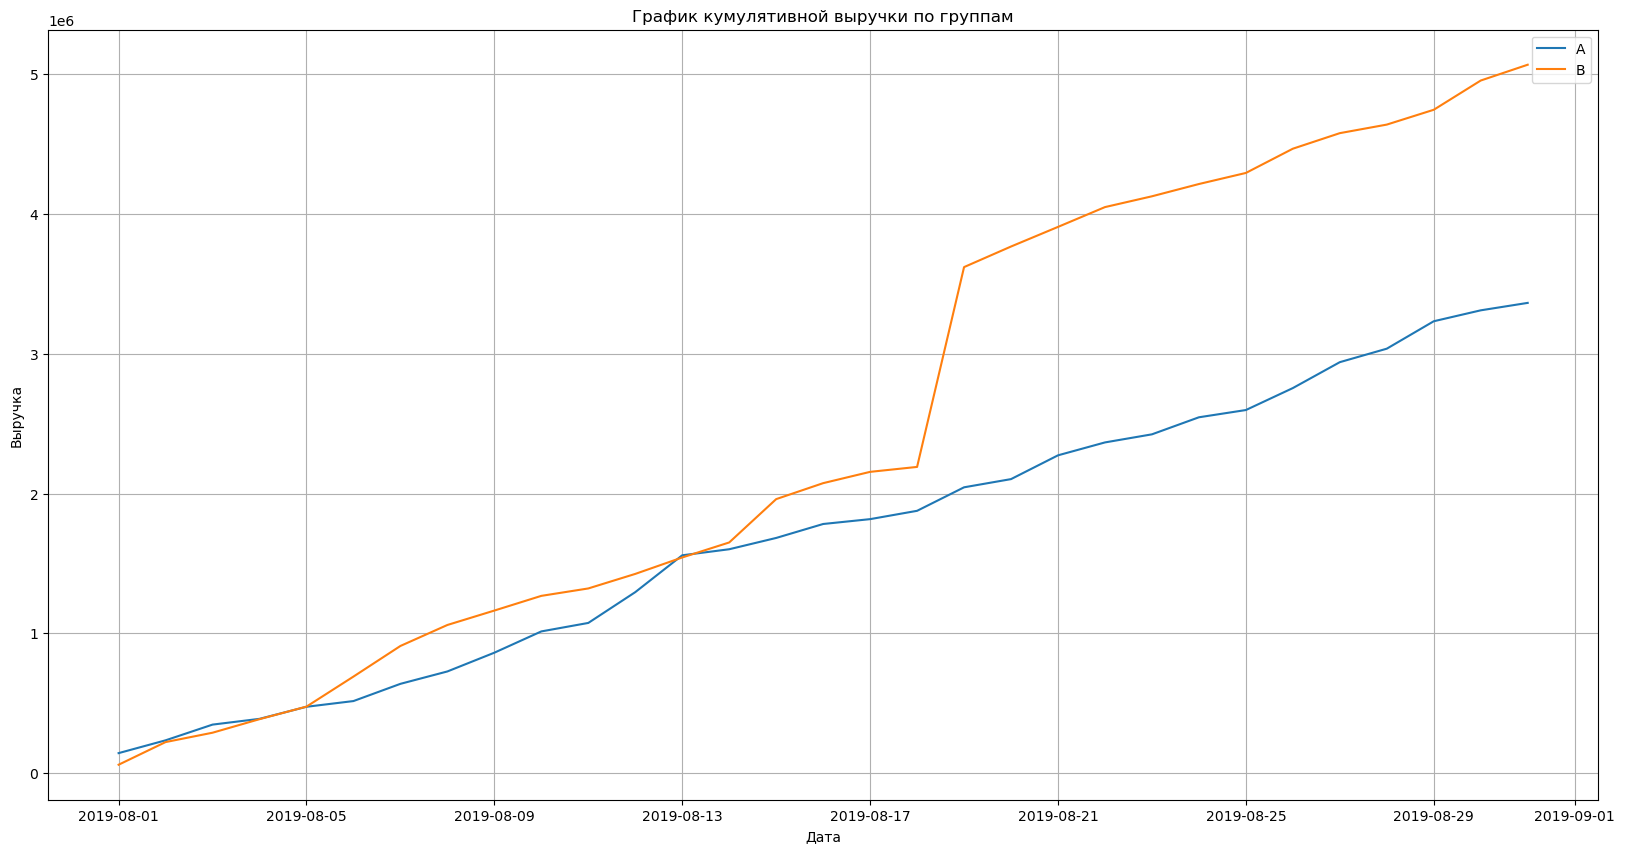

In [35]:
#  зададим размер графика
plt.figure(figsize=(20,10))
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend()

На графике видно, что c 01.08 по 18.08 выручка равномерно растет в обеих группах и показатели достаточно близки друг к другу. После 18.08 происходит скачок дохода в группе В и после этого показатели в обеих группах стабилизируются, а показатели дохода в группе В стабильно лучше, чем в группе А.\
Резкие скачки могут сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Возможные аномалии в дальнешем необходимо выявить.

- Построим график кумулятивного среднего чека по группам  — разделим кумулятивную выручку на кумулятивное число заказов

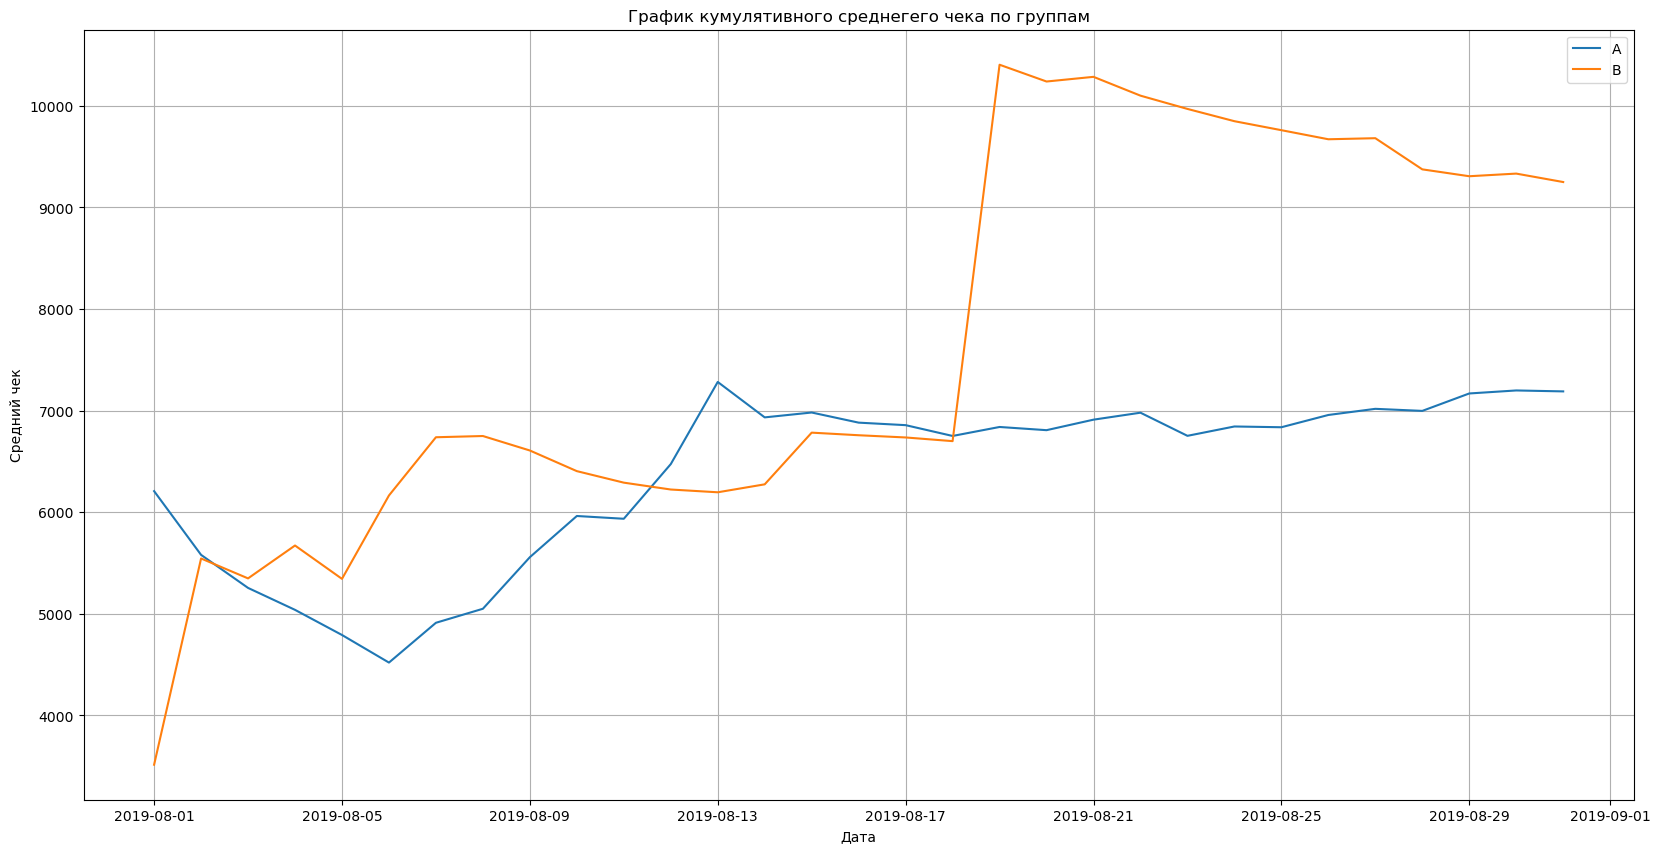

In [36]:
plt.figure(figsize=(20,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднегего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend()

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и немного снижается для группы B. В начале теста данная метрика имеет достаточно заметные колебания. \
Возможно, в группу B в первой половине теста попали крупные заказы (резкий всплеск на графике) в районе 18 августа. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

- Построим график относительного изменения кумулятивного среднего чека группы B к группе A


Text(0, 0.5, 'Отношение средних чеков группы В к группе А')

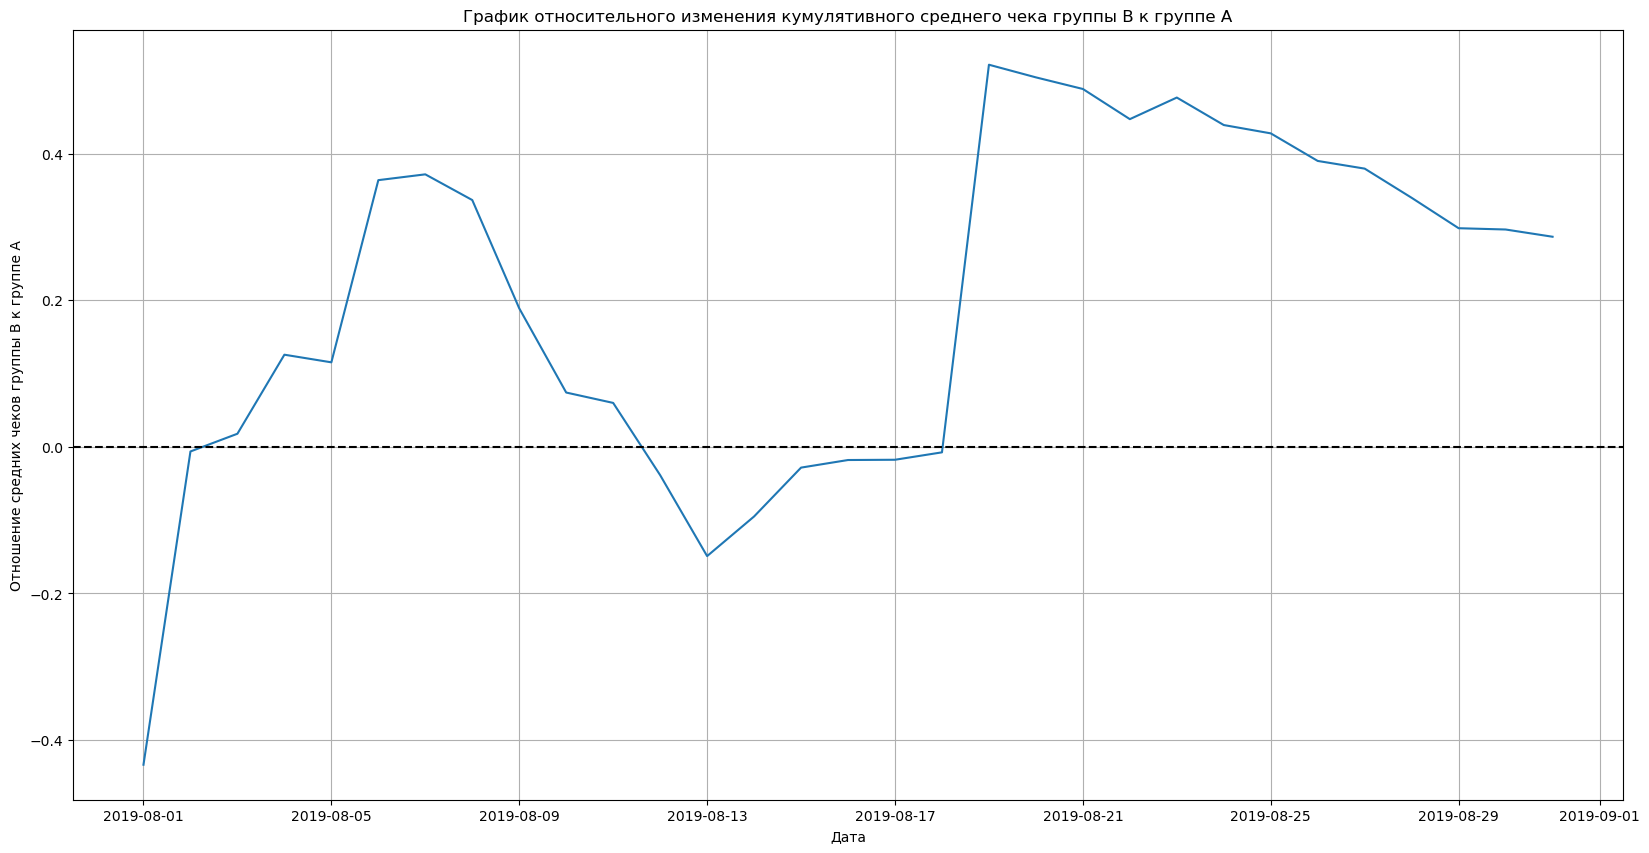

In [37]:
plt.figure(figsize=(20,10))
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков группы В к группе А')

В нескольких точках график различия между сегментами резко меняется, что сигнализирует о выбросах. В целом, в начале теста показания в группе В растут, а после 8 августа начинают понижаться. Наилучшие результаты в группе А приходятся на 13 августа. Затем после 18 августа происходит резкий скачок величины среднего чека группы В, после чего значение снижается и стабилизируется.

- Построим график кумулятивного среднего количества заказов на посетителя по группам

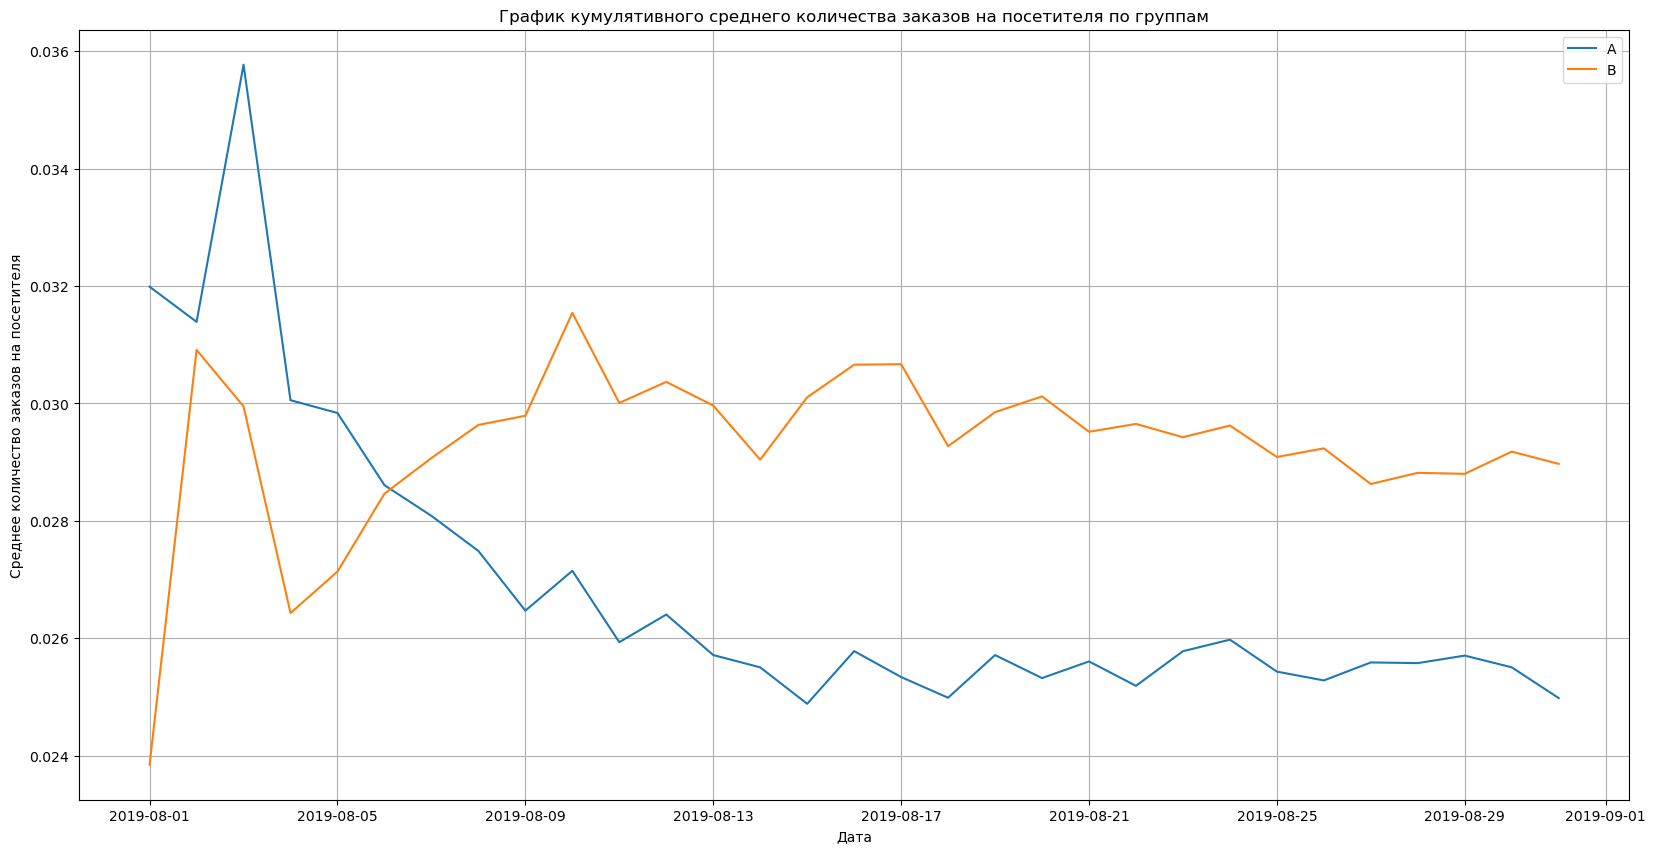

In [38]:
plt.figure(figsize=(20,10))
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.grid()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.legend()

График демонстрирует, что изначально кумулятивное среднее количество заказов на посетителя, т.е. конверсия, была лучше в группе А, но уже к 6 августа значения конверсии сравнялись, а после этого она начала последовательно расти в группе В и снижаться в группе А. В целом, значения стабилизируются и фиксируются ближе к 20 августа. Мы видим, что показатели кумулятивной конверсии стабильно лучше в группе В, нежели в группе А.

- Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

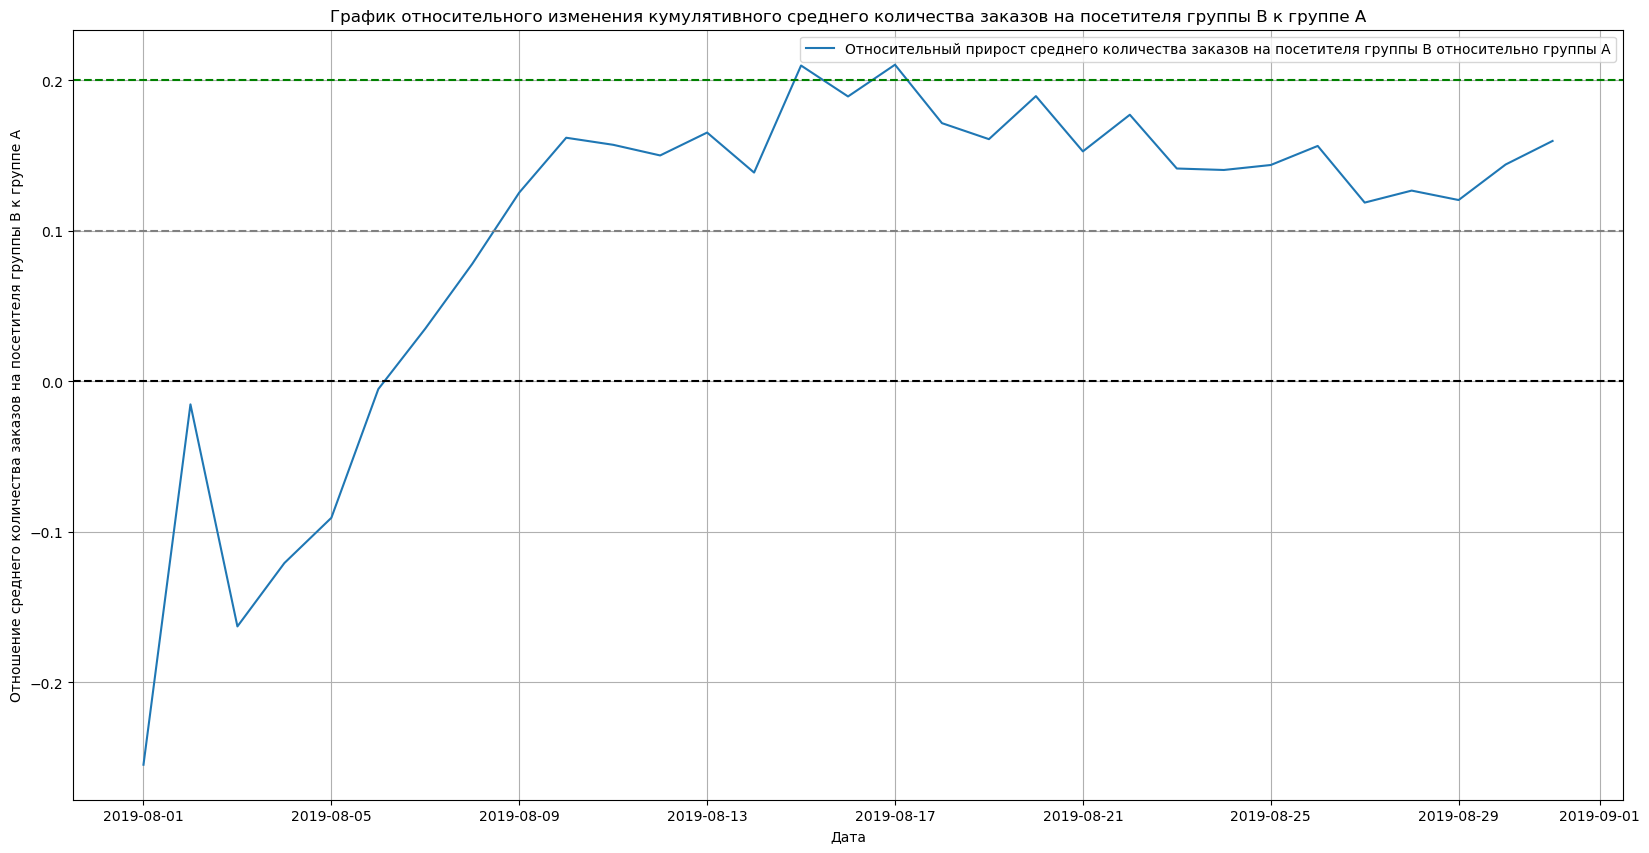

In [39]:
plt.figure(figsize=(20,10))
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост среднего количества заказов на посетителя группы B относительно группы A")
plt.grid()
plt.legend()
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.2, color='green', linestyle='--')


В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. После 6 августа данная метрика становится лучше в группе В. В целом, здесь все еще видны некоторые колебания, но среднее количество заказов в группе В стабильно лучше и стремится к фиксации.

- Построим точечный график количества заказов по пользователям
Для этого создадим сводную таблицу, в которой посчитаем, сколько каждый пользователь совершил заказов. 

In [40]:
# создаем сводную таблицу
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
# переименовываем столбцы
ordersByUsers.columns = ['userId', 'orders']
# Выведем таблицу на экран в порядке убывания числа заказво
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Из таблицы видим, что всего 7 пользователей совершили 3 заказа, остальные 2 и меньше \
Построим точечный график

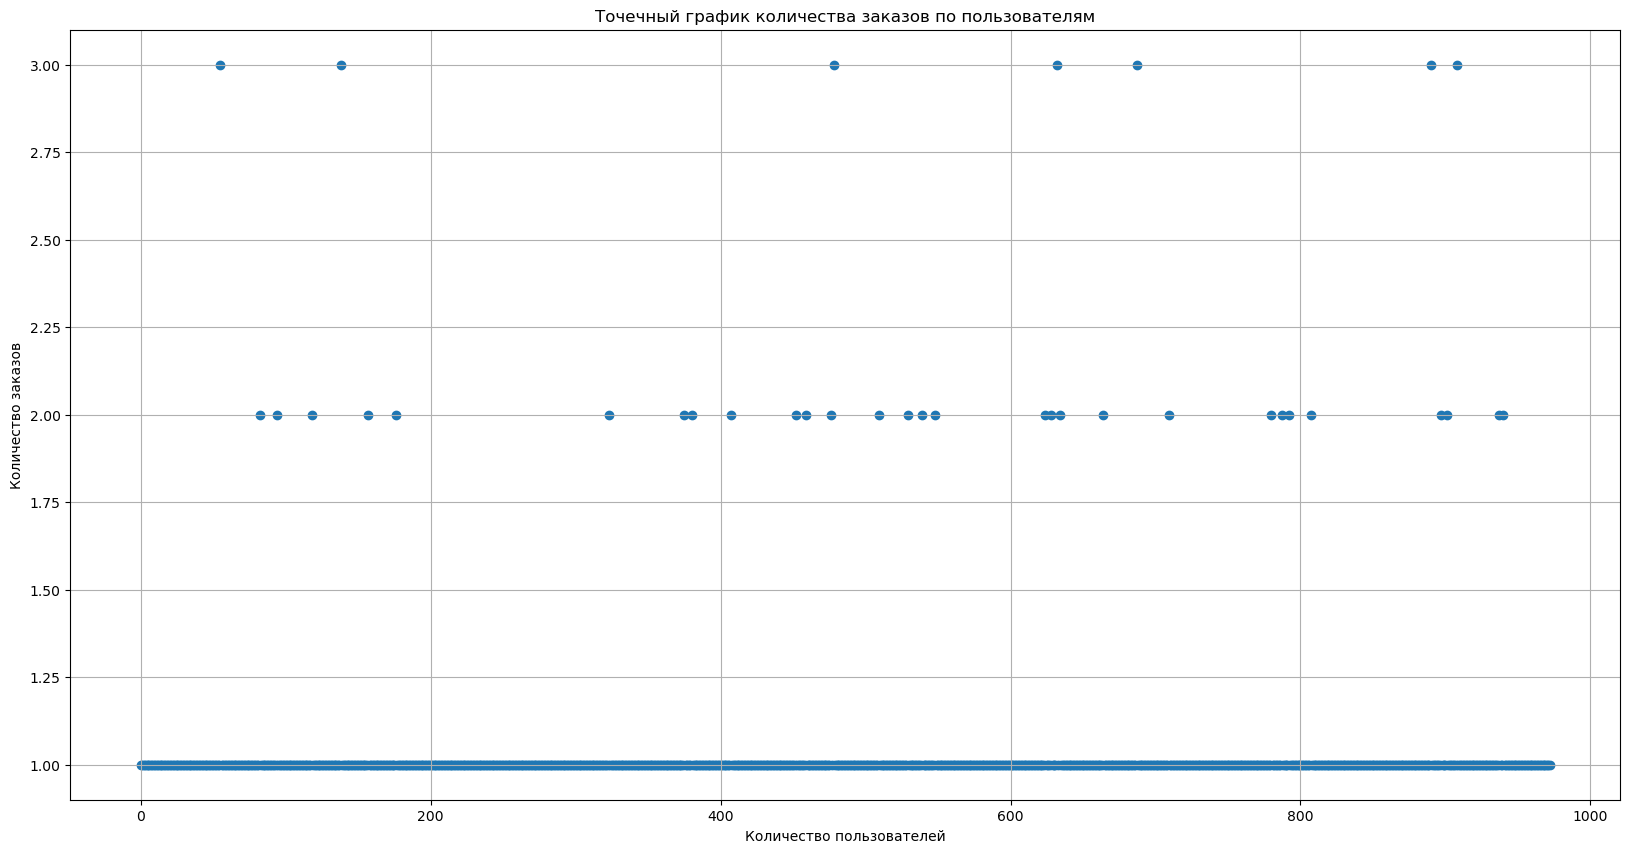

In [41]:
plt.figure(figsize=(20,10))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.grid()

На графике мы видим, что больше всего пользователи совершают по одному заказу. Также видны те самые 7 пользователей с 3 заказами. Кроме того, просматривается некоторый процент пользователей, совершивших два заказа. При этом не совсем ясно, считать ли их аномальными. Для этого посчитаем перцентили

- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [42]:
per_cnt = np.percentile(ordersByUsers['orders'], [95,99])
per_cnt

array([1., 2.])

Видим, что не более 5% пользователей совершали более одного заказа, и не более 1% - больше двух заказов.\
Разумно выбрать 1 заказ на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

- Построим точечный график стоимостей заказов

In [43]:
# посмотрим на заказы с наибольшей стоимостью из таблицы orders
orders.sort_values(by='revenue', ascending=False).head(15)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


И сразу по таблице виден аномальный заказ, стоимость которого превышает 1,2 млн, второй заказ также представляется аномальным - около 200 тыс. Все остальные заказы не превышают 100 тыс.

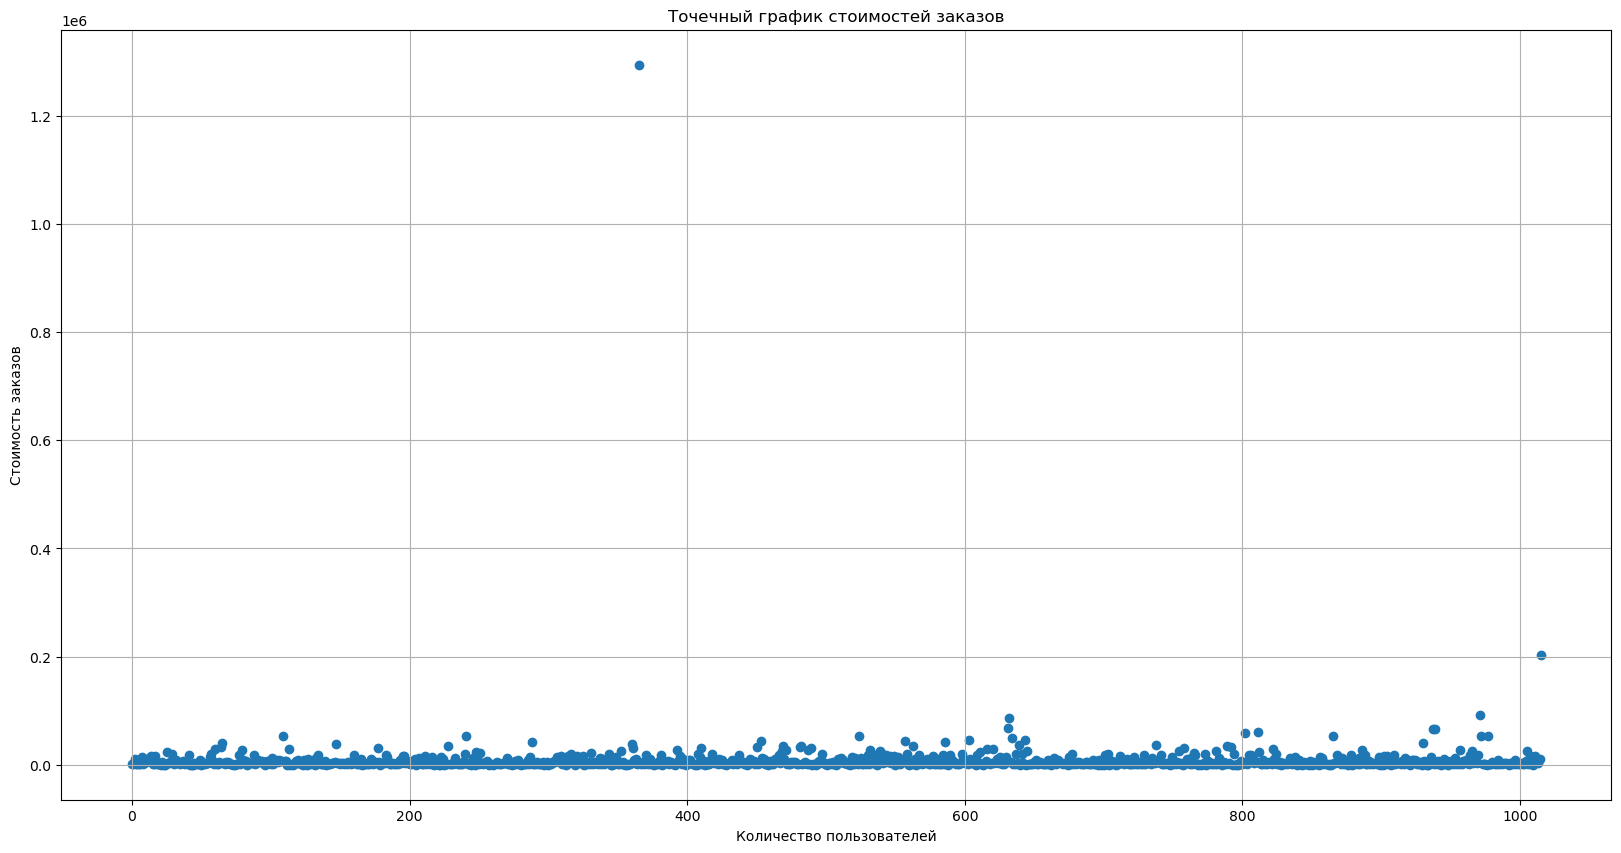

In [44]:
plt.figure(figsize=(20,10))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.grid()

Видим на графике те самые единичные дорогие заказы в районе 1,2 млн и 200 тыс. \
Рассмотрим более наглядно основную часть заказов, ограничив значения по оси Y до 100000

(0.0, 1050.0, 0.0, 100000.0)

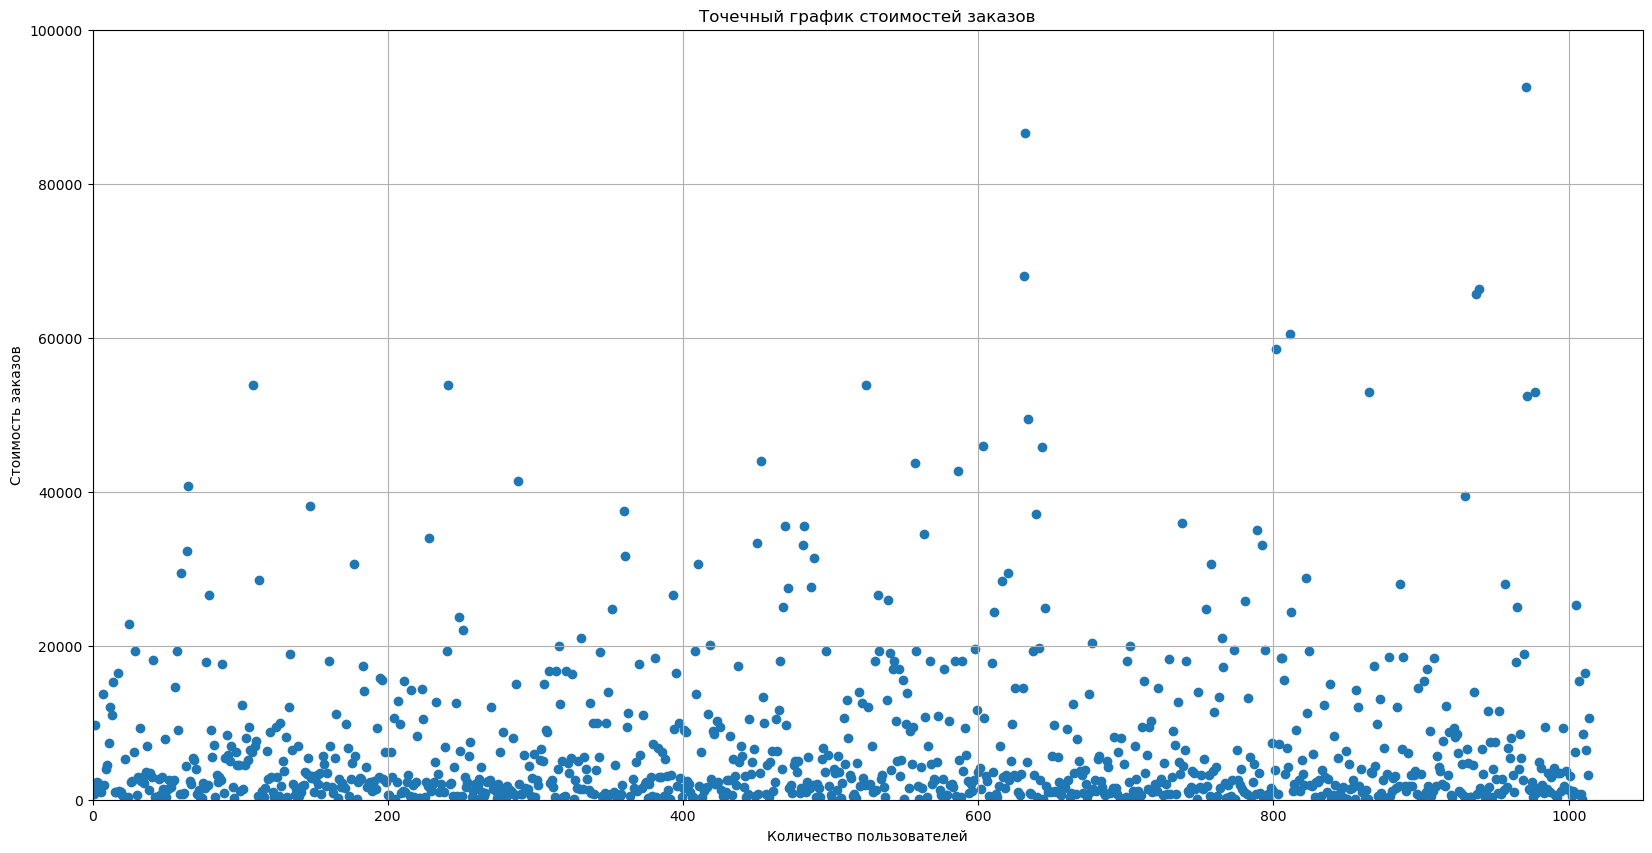

In [45]:
plt.figure(figsize=(20,10))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.grid()
# задаем масштаб осей
plt.axis([0, 1050, 0, 100000]) 

Основная часть заказов лежит в области до 20000. Также наблюдаем другие точечные значения. Для определения границ аномалий рассчитаем перцентили

- Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов

In [46]:
per_order = np.percentile(orders['revenue'], [95, 99])
per_order

array([26785., 53904.])

Не более чем у 5% заказов чек дороже 26785. И не больше, чем у 1% заказов - дороже 53904. \
Считаем целесообразно опеделить границу для определения аномальных заказов в 26785. 

- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным\
Для решения данной задачи сформулируем гипотезы. \
Н0: различий в среднем количестве заказов между группами нет. \
Н1: различия в среднем между группами есть.\
\
Значение alpha зададим в размере 0.05.\
Для проверки гипотезы будеет использовать критерий Манна-Уитни. Для этого создадим объединенную таблицу, в которую соберем все данные о визитах, числе заказов и их стоимости по каждой из групп в каждый день теста.

In [47]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [48]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.\
Переменная sampleA должна состоять из двух частей:
1. Список с количеством заказов для каждого из пользователей: ordersByUsersA['orders'].
2. Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах: data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']).\
То же делаем для sampleB\
Таким образом, в sampleA сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean(). Аналогично найдём среднее группы B: SampleB.mean().
Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой.

In [49]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print("alpha =",0.05)
print("p-value = {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего числа заказов группы B = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

alpha = 0.05
p-value = 0.011
Относительный прирост среднего числа заказов группы B = 0.160


Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. По "сырым" данным различия в конверсии между двумя группами есть. Относительный выигрыш группы B равен 16%.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. \
Сформулируем гипотезы:\
Н0:различий в среднем чеке между группами нет. \
Н1: различия в среднем чеке между группами есть. \
Для проверки гипотезы будеет использовать критерий Манна-Уитни\
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 
А ещё найдём относительные различия в среднем чеке между группами:

In [50]:
print('alpha =',0.05)
print('р-value = {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительные различия в среднем чеке между группами = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

alpha = 0.05
р-value = 0.829
Относительные различия в среднем чеке между группами = 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. средний чек группы B равен среднему чеку группы A (или не отличается). При этом относительное различие в среднем чеке по "сырым" данным все-таки есть, но оно скорее всего получено из-за выбросов.

- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным\
За аномальных пользователей примем тех, кто совершил более 1 заказа или совершил заказ дороже 26 785 рублей.\
Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 1 — usersWithManyOrders и пользователей, совершивших заказы дороже 26 785 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers

In [51]:
# Узнаем, сколько всего аномальных пользователей атрибутом shape
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > per_cnt[0]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > per_cnt[0]]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > per_order[0]]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
86


Всего 86 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по "очищенным" данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [52]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [53]:
print('alpha =',0.05)
print('р-value = {0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
р-value = 0.016
Относительный прирост среднего числа заказов группы B = 0.174


Результаты по среднему количеству заказов изменились незначительно.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [54]:
print('alpha =',0.05)
print(
    'p-value = {0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительные различия в среднем чеке между группами = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

alpha = 0.05
p-value = 0.727
Относительные различия в среднем чеке между группами = -0.034


P-value уменьшился почти на 0,1, хотя этот показатель все еще значительно больше уровня критической значимости в 0,05. А вот разница между сегментами диаметрально поменялась. Если в выборке с аномальными данными средний чек группы B выше среднего чека группы A на 28,7%, то выборка с очищенными данными показывает рост среднего чека в группе А до 3,4%. Этот результат как раз и стал возможным, благодаря тому, что мы удалили аномально дорогие заказы

- Решение по результатам теста 

Сделаем промежуточные выводы, которые позволят принять решение по проведению тестирования.
1. И по "сырым" и по "очищенным" данным различия в конверсии между двумя группами есть. Относительный выигрыш группы "B" над "A" равен 17,4% по "очищенным" и 16% по "сырым" данным.; 
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Средний чек группы B по "очищенным" данным оказался на 3,4% ниже среднего чека группы A, а вот по "сырым" данным средний чек группы В был больше на 28,7%.\
Таким образом, тест можно прекратить и признать его успешным по конверсии: группа В показывает значительно лучшие результаты по сравнению с группой А. В то же время преимущества в плане среднего чека не наблюдаются: результаты двух групп примерно одинаковы.\
\
Предполагаем, что при продолжении теста разница между группами в конверсии или среднем чеке вряд ли значимо изменится, поскольку кумулятивные графики показывают, что метрики стабилизировались.

**Выводы**\
Таким образом, была выполнена предварительная обработка данных (таблиц с гипотезами, посещениями и заказами).\
\
По результатам анализа гипотез и их показателей была произведена приоритизация гипотез по двум фреймворкам ICE и RICE. В целом, и первый и второй фреймворк покаали наиболее приоритетными для проверки следующие гипотезы:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
3. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.\
\
Анализ результатов А/В-теста показал, что тест можно прекратить и признать его успешным: показания конверсии в группе В значительно лучше, чем в группе А. При этом показатели среднего чека заказов в обеих группах не позволяют утверждать о преимуществе одной из групп.  